In [17]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm

In [27]:
data_dir0 = '../data/lunar/training/'

cat_directory = data_dir0 + 'catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

In [31]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import random
import matplotlib.pyplot as plot


def a(f=0, i=0, _STA=120, _LTA=600, _thr_on = 2.0, _thr_off = 1.5, _minfreq_filter=0.5, _maxfreq_filter=1, triggerPlot=False):
    
    #for i in range(1,len(cat)):
    for i2 in range(1,2):

        #i = random.randint(1, len(cat) - 1)
        row = cat.iloc[i]
        test_filename = row.filename

        data_directory = data_dir0 + 'data/S12_GradeA/'
        mseed_file = f'{data_directory}{test_filename}.mseed'

        catalog_directory = '../data/lunar/training/catalogs/'
        catalog_file = 'apollo12_catalog_GradeA_final.csv'
        catalog = pd.read_csv(catalog_directory + catalog_file)

        #print(catalog.loc[catalog['filename'] == test_filename])
        act_quake_cat = catalog.loc[catalog['filename'] == test_filename, 'time_rel(sec)'].values[0]
        #print(act_quake_cat)

        try:
            st = read(mseed_file)
        except FileNotFoundError:
            print(f"File {mseed_file} not found. Skipping to next iteration.")
            continue

        # This is how you get the data and the time, which is in seconds

        if(f==0):
            tr = st.traces[0].copy()
            tr_times = tr.times()
            tr_data = tr.data
        else:
            minfreq = _minfreq_filter
            maxfreq = _maxfreq_filter
            st_filt = st.copy()

            #st_filt.filter('bandpass',freqmin=_minfreq_filter,freqmax=_maxfreq_filter)

            st_filt.filter('lowpass',freq=_maxfreq_filter)
            st_filt.filter('highpass',freq=_minfreq_filter)

            tr_filt = st_filt.traces[0].copy()
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data
            # This is how you get the data and the time, which is in seconds
            tr = tr_filt.copy()
            tr_times = tr_times_filt.copy()
            tr_data = tr_data_filt.copy()

        fp, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate, nperseg=256, noverlap=128, scaling='density')
        vmax = sxx.max()
        vmin = sxx.min()
    

        # Sampling frequency of our trace
        df = tr.stats.sampling_rate

        # How long should the short-term and long-term window be, in seconds?
        sta_len = _STA
        lta_len = _LTA

        # Run Obspy's STA/LTA to obtain a characteristic function
        # This function basically calculates the ratio of amplitude between the short-term 
        # and long-term windows, moving consecutively in time across the data
        cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

        # Plot characteristic function
        fig, (ax, ax1 ,ax2) = plt.subplots(3, 1, figsize=(12, 8))
        
        
        if (triggerPlot == True):
            thr_on = _thr_on
            thr_off = _thr_off
            on_off = np.array(trigger_onset(cft, thr_on, thr_off))
            # The first column contains the indices where the trigger is turned "on". 
            # The second column contains the indices where the trigger is turned "off".

            for i in np.arange(0,len(on_off)):
                triggers = on_off[i]
                ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
                ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
    
        ax.plot(tr_times,tr_data)
        ax.set_xlim([min(tr_times),max(tr_times)])
        ax.set_ylabel('Velocity (m/s)')
        #ax.set_xlabel('Time (s)')
        ax.set_title('Unfiltered' if f == 0 else f'Filtered - bandpass [{minfreq}-{maxfreq}]')
        #ax.set_title(f'{test_filename}', fontweight='bold') 

        # Plot characteristic function
        ax1.plot(tr_times, cft)
        #ax1.set_title('Unfiltered' if f == 0 else f'Filtered - bandpass [{minfreq} {maxfreq}]')
        ax1.set_xlim([min(tr_times), max(tr_times)])
        #ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Characteristic function')
        ax1.axvline(x=act_quake_cat, c='red')
        #ax1.legend()

        ## Plot spectr1
        #powerSpectrum, freqenciesFound, time, imageAxis = ax15.specgram(tr_data, Fs=df)

        # Plot spectrogram
        vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = vmin, vmax=vmax)

        ax2.set_xlim([min(tr_times), max(tr_times)])
        ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
        ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
        
        #cbar = plt.colorbar(vals, ax=ax2, orientation='horizontal')
        #cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

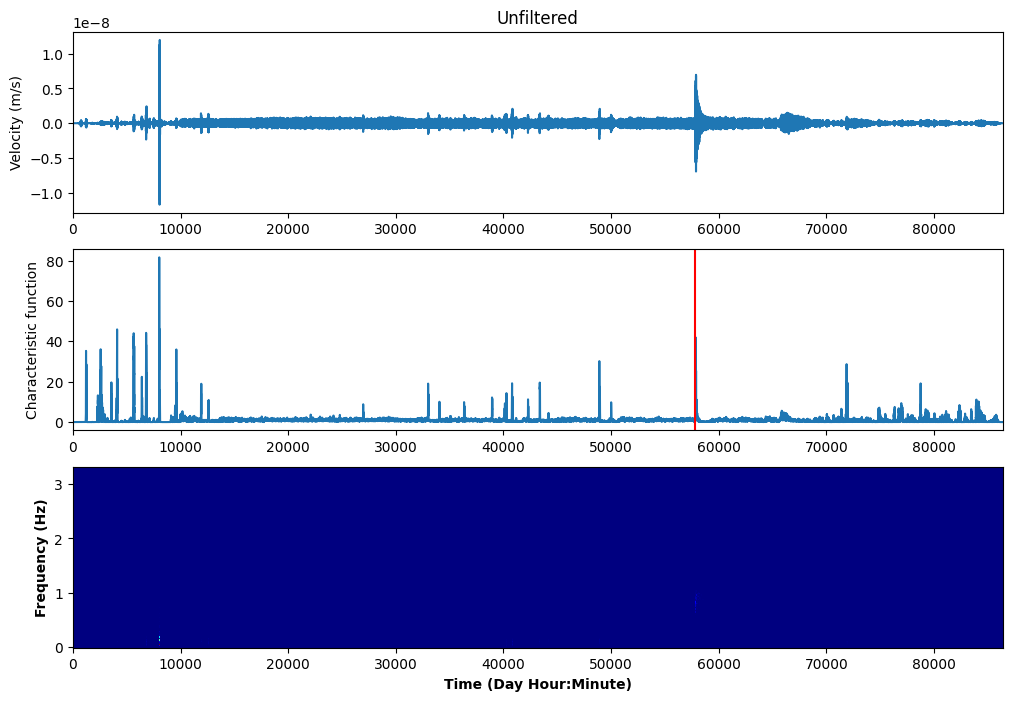

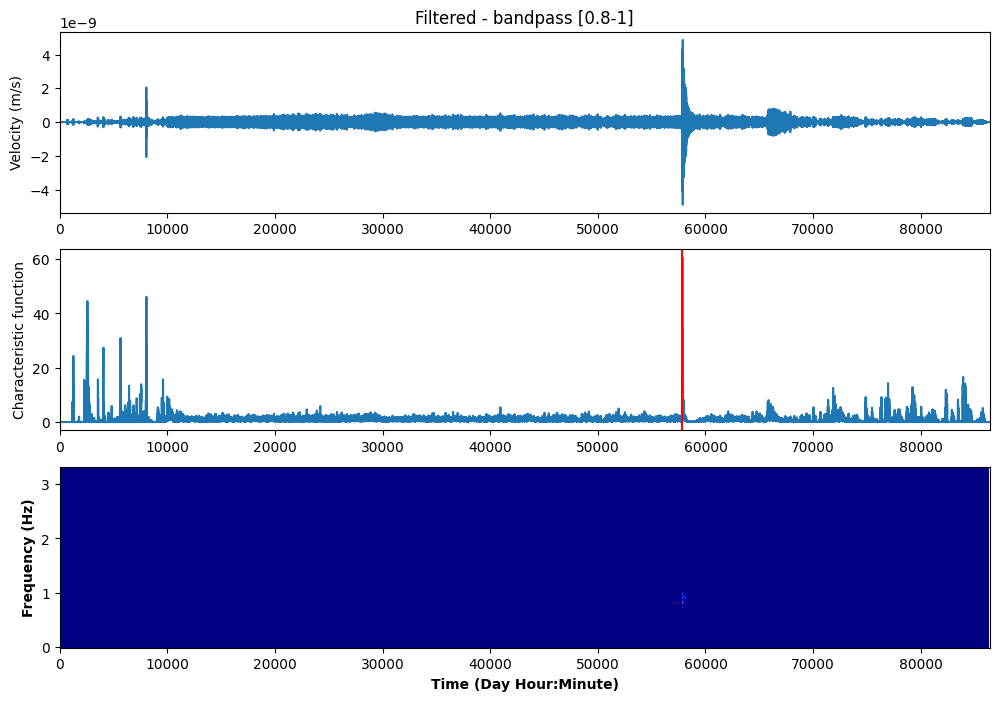

In [32]:
for j in range(1,2):
    
    i = random.randint(1, len(cat) - 1)

    sta = 10
    lta= 1000
    thr_on = 2.5
    thr_off = 1
    min_cut = 0.8
    max_cut = 1


    a(0,i,sta, lta, _thr_on = thr_on, _minfreq_filter = min_cut, _maxfreq_filter = max_cut, triggerPlot=False)    
    a(1,i,sta, lta, _thr_off = thr_off, _minfreq_filter = min_cut, _maxfreq_filter = max_cut, triggerPlot=False)

In [ ]:
#-------------------------------------------------------------------------------------------------------------